<a href="https://colab.research.google.com/github/ap2313/DSBDA/blob/main/lung_cancer_using_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [2]:
DATADIR='/content/Lungcancer'
CATEGORIES=['lung_adenocarcinomous','lung_normal','lung_squamous_cell_carcinomous']

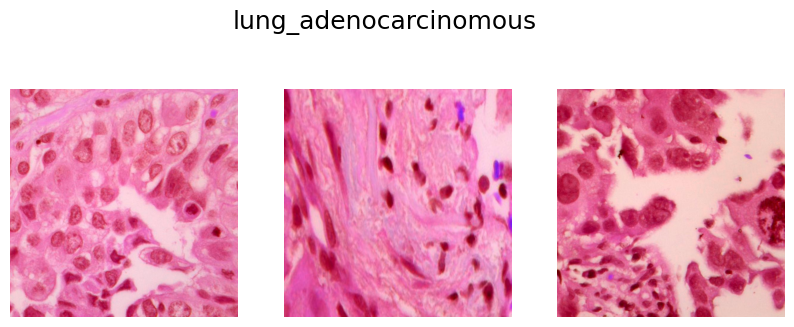

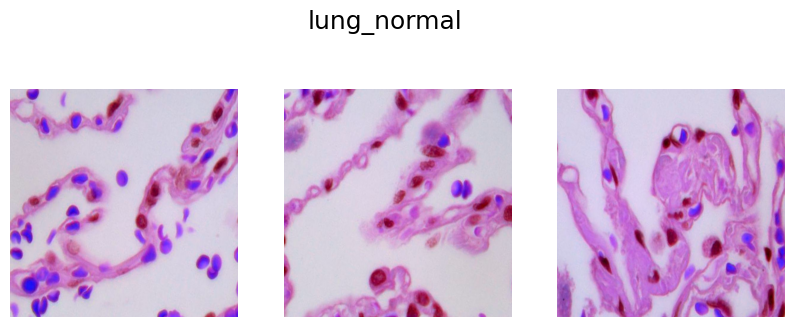

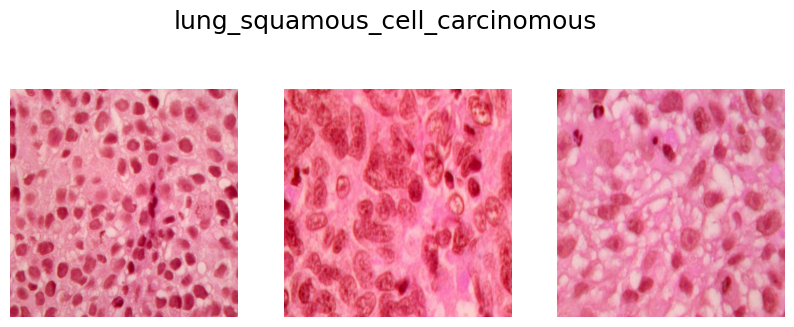

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2        #to read the image data

for category in CATEGORIES:
  path=os.path.join(DATADIR,category)
  images = os.listdir(path)

  fig, ax=plt.subplots(1,3, figsize=(10,4))
  fig.suptitle(f'{category}', fontsize=18)

  for i in range(3):
    img_name=images[np.random.randint(0, len(images))]
    img_path=os.path.join(path,img_name)
    img_array=cv2.imread(img_path)

    ax[i].imshow(img_array)
    ax[i].axis('off')

In [6]:
img_array.shape

(768, 768, 3)

In [7]:
IMG_SIZE=224
new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

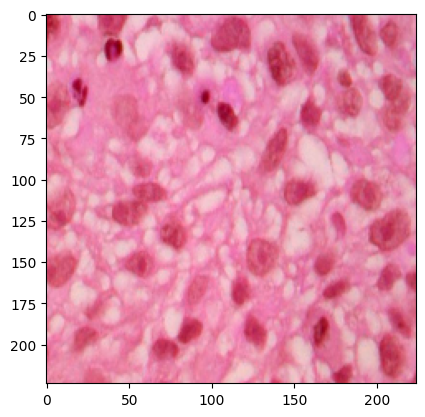

In [8]:
plt.imshow(new_array)

In [9]:
new_array.shape

(224, 224, 3)

In [10]:
#creating training data

training_data=[]

def create_train_data():
  for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    labels=CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array=cv2.imread(os.path.join(path,img))
        new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        training_data.append([new_array,labels])
      except Exception as e:
        pass

create_train_data()


In [11]:
len(training_data)

15000

In [12]:
x=[]
y=[]

for features, labels in training_data:
  x.append(features)
  y.append(labels)

In [13]:
type(x) , type(y)

(list, list)

In [14]:
x=np.array(x).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y=np.array(y)

In [15]:
type(x),type(y)

(numpy.ndarray, numpy.ndarray)

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [17]:
print(f'x_train Length:{x_train.shape[0]},x_train Imgage size:{x_train.shape[1:3]},x_train Channel Dimension:{x_train.shape[3]}')
print(f'x_test Length:{x_test.shape[0]},x_test Imgage size:{x_test.shape[1:3]},x_test Channel Dimension:{x_test.shape[3]}')

x_train Length:12000,x_train Imgage size:(224, 224),x_train Channel Dimension:3
x_test Length:3000,x_test Imgage size:(224, 224),x_test Channel Dimension:3


In [18]:
##  vgg16 model building

import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16


In [19]:
vgg= vgg16.VGG16(weights='imagenet',include_top= False,input_shape=(IMG_SIZE,IMG_SIZE,3))

In [20]:
#frezing convolutional layers

for layer in vgg.layers:
  layer.trainable=False


In [21]:
#adding top layers

model=keras.Sequential([
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.fit(x_train,y_train,epochs=5)

Epoch 1/5
375/375 [==============================] - 55s 115ms/step - loss: 0.1972 - accuracy: 0.9427
Epoch 2/5
375/375 [==============================] - 44s 117ms/step - loss: 0.0726 - accuracy: 0.9718
Epoch 3/5
375/375 [==============================] - 45s 120ms/step - loss: 0.0625 - accuracy: 0.9772
Epoch 4/5
375/375 [==============================] - 45s 121ms/step - loss: 0.0419 - accuracy: 0.9854
Epoch 5/5
375/375 [==============================] - 46s 122ms/step - loss: 0.0315 - accuracy: 0.9877


In [24]:
loss , accuracy=model.evaluate(x_test,y_test)
print(f'Model Accuracy: {accuracy*100}')

94/94 [==============================] - 16s 172ms/step - loss: 0.0455 - accuracy: 0.9863
Model Accuracy: 98.63333106040955


In [26]:
pred= np.argmax(model.predict(x_test),axis=-1)

94/94 [==============================] - 11s 120ms/step


In [27]:
pred

array([2, 1, 2, ..., 2, 2, 2])

In [29]:
y_test[:5]

array([2, 1, 2, 0, 1])

In [30]:
pred[:5]

array([2, 1, 2, 0, 1])

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1037
           1       1.00      1.00      1.00       970
           2       0.97      0.99      0.98       993

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



Text(50.722222222222214, 0.5, 'Actual')

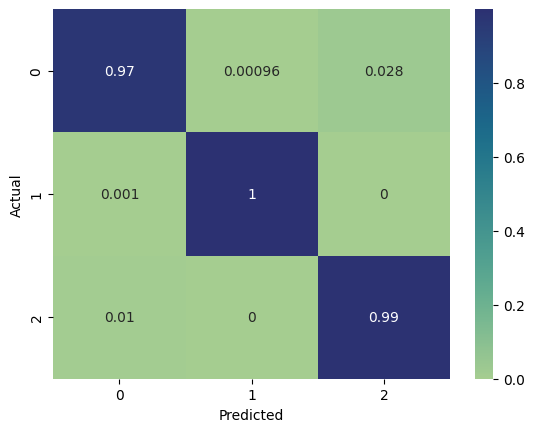

In [38]:
cf=confusion_matrix(y_test,pred,normalize='true')
import seaborn as sns
sns.heatmap(cf,annot=True,cmap='crest')
plt.xlabel('Predicted')
plt.ylabel('Actual')